In [1]:
import os

# Show current working directory
print("Before:", os.getcwd())

# Go two folders up
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# Show new working directory
print("After:", os.getcwd())


from src.scm.ncm.time_causal_vae import C_VAE
from src.scm.prior.realnvp import FlowPrior
import torch as T
import pandas as pd

data = pd.read_csv("Experiments\Sythetic_DAG_data\synth_data_back_door.csv")
window_size = 6
batch_size = 500
latent_dim = 64
input_dim = data.shape[1]
seq_length = window_size
batch_size = 500

num_flows = 5 
hidden_dim = 128 

prior = {node: FlowPrior(num_flows=num_flows, 
                                latent_dim=latent_dim, 
                                hidden_dim=hidden_dim) for node in range(input_dim+1)}

device = T.device("cuda" if T.cuda.is_available() else "cpu")

# Initialize model
model = C_VAE(
    latent_dim=latent_dim,
    input_dim=input_dim,
    seq_length=seq_length,
    batch_size=batch_size,
    prior=prior,
    device=device
)

import torch as T

ckpt_path = "model_weights/c_vae/synth_data_vae/last.ckpt"
checkpoint = T.load(ckpt_path, map_location="cpu")
new_state_dict = {}
for key in checkpoint['state_dict'].keys():
    new_key = key.replace("vae.", "")
    new_state_dict[new_key] = checkpoint['state_dict'][key]

# Then replace the old state_dict with the new one
checkpoint['state_dict'] = new_state_dict

model.load_state_dict(checkpoint['state_dict'])

Before: c:\Users\luiso\OneDrive\Documents\neurIPS\sceana\Experiments\Sythetic_DAG_data
After: c:\Users\luiso\OneDrive\Documents\neurIPS\sceana


<All keys matched successfully>

In [2]:
window_size

6

In [3]:
data.shape[1]

2

In [4]:
import numpy as np

data = pd.read_csv("Experiments\Sythetic_DAG_data\synth_data_back_door.csv")

window_size = 5

windows = np.lib.stride_tricks.sliding_window_view(data.values, (window_size, data.shape[1]))

# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, data.shape[1])

In [5]:
windows.shape

(9996, 5, 2)

In [6]:
#Probability if x is not ctf

def get_ctf_bounds(data_set_sam, idx_win, thres_x, thres_y):
    #y_t = lambda x_t_1, y_t_1, e: .5*y_t_1 + 2*x_t_1 + e
    #x_t = lambda x_t_1, e: .5*x_t_1 + e
    theta_x, sigma_x = 0.2, 0.5
    theta_y, sigma_y, beta = 0.3, 0.6, 0.5

    x_t = lambda x_prev, eta: x_prev - theta_x * x_prev + sigma_x * eta
    y_t = lambda x_prev, y_prev, eps: y_prev - theta_y * y_prev + beta * x_prev + sigma_y * eps
    all_y_no_ctf_x = []
    all_y_ctf_x = []
    no_ctf_x = []
    ctf_x = []
    N = data_set_sam.shape[0]

    temp_cont_x = 0
    for i in range(N):
        temp_x = data_set_sam[i, idx_win-1, 0]
        if temp_x >= thres_x:
            temp_y = data_set_sam[i, idx_win-1, 1]
            all_y_no_ctf_x.append(y_t(temp_x, temp_y, np.random.normal()))
            #all_y_no_ctf_x.append(x_t(temp_x, np.random.normal()))
            temp_cont_x += 1

        else:
            temp_y = data_set_sam[i, idx_win-1, 1]
            all_y_ctf_x.append(y_t(temp_x, temp_y, np.random.normal()))
            #all_y_ctf_x.append(x_t(temp_x, np.random.normal()))

    no_ctf_x = temp_cont_x/N
    ctf_x = 1 - (temp_cont_x/N)
    no_ctf_y_no_ctf_x = np.sum([j > thres_y for j in all_y_no_ctf_x])/N
    no_ctf_y_ctf_x = np.sum([j > thres_y for j in all_y_ctf_x])/N
    ctf_y_ctf_x = np.sum([j <= thres_y for j in all_y_ctf_x])/N

    P_ctf_y_ctf_x = ctf_y_ctf_x/ctf_x
    P_y_ctf_x = no_ctf_y_ctf_x/ctf_x
    P_y_x = no_ctf_y_no_ctf_x/no_ctf_x

    l_b = max(0, 1 - P_y_ctf_x/P_y_x)
    r_b = max(1, P_ctf_y_ctf_x/P_y_x)

    return l_b, r_b


In [7]:
def give_ctf_gt_probs(idx, seed, n_steps, thres_x, thres_y):

    #thres_x = 2
    #thres_y = 1

    n_samples = 10000
    do = {"0": {idx-1: thres_x}}

    ctf_samp, _ = model.ctf_decoder(do, n_samples, n_steps, seed)
    #ctf_samp = model.sample(n_samples, n_steps)

    ctf_prob = np.mean(ctf_samp[:, idx, 1].numpy() > thres_y)

    np.random.seed(seed)

    #z_t = lambda z_t_1, e: .5*z_t_1 + e
    #x_t = lambda x_t_1, e: .5*x_t_1 + e
    #y_t = lambda x_t_1, y_t_1, e: .5*y_t_1 + 2*x_t_1 + e
    theta_x, sigma_x = 0.2, 0.5
    theta_y, sigma_y, beta = 0.3, 0.6, 0.5

    x_t = lambda x_prev, eta: x_prev - theta_x * x_prev + sigma_x * eta
    y_t = lambda x_prev, y_prev, eps: y_prev - theta_y * y_prev + beta * x_prev + sigma_y * eps

    #z_sam_t_1 = ctf_samp[:, idx-1, 0]
    x_sam_t_1 = ctf_samp[:, idx-1, 0]
    #print(x_sam_t_1)
    y_sam_t_1 = ctf_samp[:, idx-1, 1]
    g_t_samp = y_t(x_sam_t_1, y_sam_t_1, np.random.normal(0,1)).numpy()
    #print(g_t_samp.shape)
    #g_t_samp = x_t(x_sam_t_1, np.random.normal(0,1)).numpy()
    g_t_prob = np.mean(g_t_samp > thres_y)

    return g_t_prob, ctf_prob, ctf_samp

In [8]:
n_samples = 500
tempi = model.sample(n_samples,20).detach().numpy()
idx = 5
cont_y = 0
thres_x = 1
thres_y = 0
#jeje = 
for i in range(tempi.shape[0]):
    if tempi[i,idx-1,0] >= thres_x:
        if tempi[i,idx,1] > thres_y:
            cont_y += 1

In [9]:
tempi = model.sample(n_samples,6).detach().numpy()
#tempi

In [10]:
cont_y/n_samples

0.032

In [11]:
all_gt_probs = []
all_ctf_probs = []
thres_x = 0
thres_y = 0

n_steps = 6

for i in range(10):
    temp_1 = []
    temp_2 = []
    l_b = []
    r_b = []

    for idx in range(1, n_steps):
        #if idx % 1:
        g_t_temp, ctf_temp, ctf_samples = give_ctf_gt_probs(idx,idx*(i+1),idx+1, thres_x, thres_y)

        temp_l_b, temp_r_b = get_ctf_bounds(ctf_samples, idx, thres_x, thres_y)

        temp_1.append(g_t_temp)
        temp_2.append(ctf_temp)

        l_b.append(temp_l_b)
        r_b.append(temp_r_b)

    all_gt_probs.append(temp_1)
    all_ctf_probs.append(temp_2)

In [12]:
real_prob = [np.mean(i) for i in list(zip(*all_gt_probs))]
avg_ctf_prob = [np.mean(i) for i in list(zip(*all_ctf_probs))]
real_prob, avg_ctf_prob

([np.float64(0.63864),
  np.float64(0.5863499999999999),
  np.float64(0.56179),
  np.float64(0.5834900000000001),
  np.float64(0.41786)],
 [np.float64(0.46887),
  np.float64(0.4760699999999999),
  np.float64(0.47912999999999994),
  np.float64(0.47761),
  np.float64(0.47601000000000004)])

In [13]:
d1 = [np.abs(x - y) for x, y in zip(real_prob, avg_ctf_prob)]
d1

[np.float64(0.16976999999999998),
 np.float64(0.11028000000000004),
 np.float64(0.08266000000000007),
 np.float64(0.10588000000000009),
 np.float64(0.058150000000000035)]

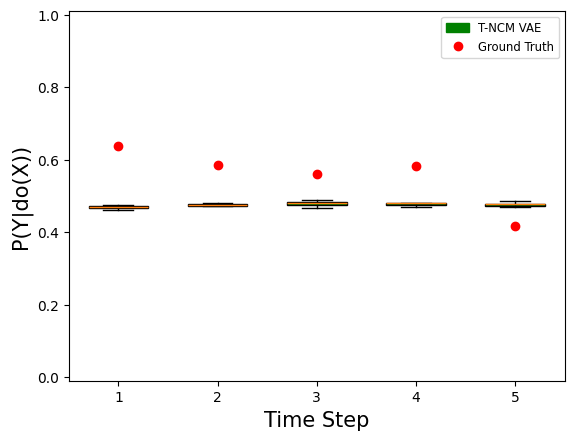

In [14]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
temp = list(zip(*all_ctf_probs))

fig, ax = plt.subplots()
len_dat = len(temp)
# Plot each box plot separately
positions = np.arange(1, len_dat+1)
#positions = np.arange(1, 20+1)
capprops = dict(color='blue', linewidth=2)

#low_b, = plt.plot(positions,l_b,linestyle="--",label='Lower bound')
#up_b, = plt.plot(positions,r_b,linestyle="--",label='Upper bound')

plt.ylim(-.01, 1.01)
for i in range(len_dat):
    bp = ax.boxplot(temp[i], positions=[positions[i]], widths=0.6, showfliers=False, patch_artist=True)

    for box in bp['boxes']:
        box.set_facecolor('green')

ground_truth, = plt.plot(np.arange(1, len_dat+1),real_prob, marker='o', linestyle='', color='red', label="Ground Truth")
# Customize the plot
ax.set_ylabel('P(Y|do(X))', fontsize=15)
ax.set_xlabel('Time Step', fontsize=15)
# Set the x-axis labels
ax.set_xticks(positions)
boxplot_patch = Patch(color='green', label='T-NCM VAE')
#plt.legend(handles=[boxplot_patch, ground_truth, low_b, up_b], labels=['T-NCM VAE', 'Ground Truth', 'Lower bound', 'Upper bound'], loc='upper right', fontsize='small')
plt.legend(handles=[boxplot_patch, ground_truth], labels=['T-NCM VAE', 'Ground Truth'], loc='upper right', fontsize='small')
plt.show()